# LAB 3

Jean-Loup Mellion  
Gatien Da Rocha

# Imports / CUDA

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

%matplotlib inline
np.random.seed(7)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda
Thu Jun  6 17:22:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:06:00.0 Off |                  N/A |
| 81%   58C    P8             35W /  300W |       4MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

# Params

The parameters used in all the following models

In [2]:
EPOCHS = 256
BATCH_SIZE = 256

# Dataset

We add some transformations to the dataset, color jittering, cropping, flipping, and normalization.  
Normalization is not exactly the one recommended for CIFAR10, but it is the one used by ResNet and SqueezeNet, so we will use it for the sake of comparison.

In [3]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

train_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=14)

validation_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

validation_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=validation_transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=14)

print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape)
print(labels.shape)

Files already downloaded and verified
Files already downloaded and verified
Train size :  50000
validation size :  10000
torch.Size([256, 3, 32, 32])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.3891084].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.695148..0.92322075].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56914604..1.6427422].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7048404..1.7492281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6079159..1.1076493].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.6817627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7145

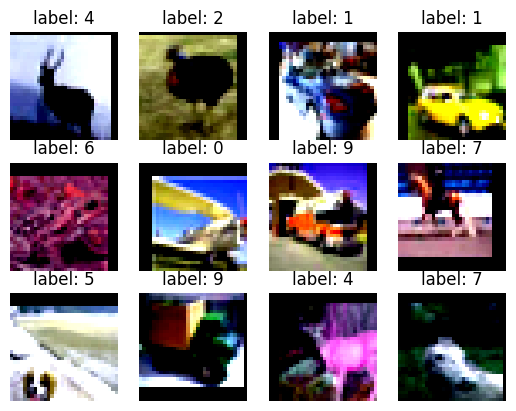

In [4]:
for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

# Training / Plotting / Evaluation functions

In [5]:
def train_model(
        model: torch.nn.Module,
        trainLoader: torch.utils.data.DataLoader,
        validationLoader: torch.utils.data.DataLoader,
        train_set: torch.utils.data.Dataset,
        validation_set: torch.utils.data.Dataset,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: str,
        model_path: str,
        save_every: int,
        epochs: int = 8
) -> tuple:
    train_loss, val_loss = [], []
    accuracy_total_train, accuracy_total_val = [], []
    start_time = time.time()
    last_time = start_time

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0
        model.train()
        total = 0

        for idx, (image, label) in enumerate(trainLoader):
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()

            pred = model(image)
            loss = criterion(pred, label)

            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total += 1

        accuracy_train = total / len(train_set)
        accuracy_total_train.append(accuracy_train)
        total_train_loss = total_train_loss / (idx + 1)
        train_loss.append(total_train_loss)

        model.eval()
        total = 0

        with torch.no_grad():
            for idx, (image, label) in enumerate(validationLoader):
                image, label = image.to(device), label.to(device)

                pred = model(image)
                loss = criterion(pred, label)

                total_val_loss += loss.item()
                pred = torch.nn.functional.softmax(pred, dim=1)
                for i, p in enumerate(pred):
                    if label[i] == torch.max(p.data, 0)[1]:
                        total += 1

        accuracy_val = total / len(validation_set)
        accuracy_total_val.append(accuracy_val)
        total_val_loss = total_val_loss / (idx + 1)
        val_loss.append(total_val_loss)

        print("Epoch: {}/{}  ".format(epoch + 1, epochs),
              "Train loss: {:.4f}  ".format(total_train_loss),
              "Valid loss: {:.4f}  ".format(total_val_loss),
              "Train acc: {:.4f}  ".format(accuracy_train),
              "Valid acc: {:.4f}  ".format(accuracy_val),
              "Elapsed time: {:.4f} sec  ".format(time.time() - start_time),
              "Time left: {:.4f} sec".format((time.time() - last_time) * (epochs - epoch - 1)))

        last_time = time.time()

        if epoch != 0 and save_every != 0 and (epoch + 1) % save_every == 0:
            torch.save(model.state_dict(), model_path + "epoch_" + str(epoch) + ".pt")
            print("Model saved!")

    total_time = time.time() - start_time

    return train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time

In [6]:
def plot_loss(train_loss: list, val_loss: list):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per epoch')
    plt.show()

In [7]:
def plot_accuracy(accuracy_total_train: list, accuracy_total_val: list):
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_total_train, label='Training accuracy')
    plt.plot(accuracy_total_val, label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per epoch')
    plt.show()

In [8]:
def test_accuracy(model: torch.nn.Module, validationLoader: torch.utils.data.DataLoader, validation_set: torch.utils.data.Dataset, device: str) -> float:
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            pred = model(image)
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

    accuracy = total / len(validation_set)
    return accuracy

In [9]:
def trainable_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()))

# From scratch model

### Model

In [10]:
class ResidualBlock(torch.nn.Module):
    """
    Residual block with three convolutions
    """ 
    def __init__(self, in_channels: int = 3, out_channels: int = 64, kernel_size: int = 3, padding: int = 1):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.prelu1 = torch.nn.PReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.prelu2 = torch.nn.PReLU()
        self.residual_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0) if in_channels != out_channels else None
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        residual = x
        out = self.conv1(x) # in, w, h -> out, w, h
        out = self.bn1(out) # out, w, h
        out = self.prelu1(out) # out, w, h
        out = self.conv2(out) # out, w, h -> out, w, h
        out = self.bn2(out) # out, w, h
        if self.residual_conv: 
            residual = self.residual_conv(x) # in, w, h -> out, w, h
        out += residual # out, w, h
        out = self.prelu2(out) # out, w, h
        out = self.maxpool(out) # out, w, h -> out, w/2, h/2
        return out
        
    
class Classifier(torch.nn.Module):
    """
    Simple classifier with two fully connected layers
    """
    def __init__(self, in_channels: int):
        super().__init__()
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc1 = torch.nn.Linear(in_channels, 128)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, out):
        out = out.view(out.size(0), -1) # 2x2x256 -> 2048
        out = self.dropout1(out) # 2048
        out = self.fc1(out) # 2048 -> 128
        out = self.dropout2(out) # 128
        out = self.fc2(out) # 128 -> 10
        return out

class FromScratch(torch.nn.Module):
    """
    Model from scratch, inspired by ResNet models
    """
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.batchnorm = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.block1 = ResidualBlock(64, 96, kernel_size=3, padding=1)
        self.block2 = ResidualBlock(96, 128, kernel_size=3, padding=1)
        self.block3 = ResidualBlock(128, 196, kernel_size=3, padding=1)
        self.block4 = ResidualBlock(196, 256, kernel_size=3, padding=1)
        self.classifier = Classifier(256 * 2 * 2)
    
    def forward(self, out):
        out = self.conv(out) # 32x32x3 -> 32x32x64
        out = self.batchnorm(out) # 32x32x64
        out = self.relu(out) # 32x32x64
        out = self.block1(out) # 32x32x64 -> 16x16x96
        out = self.block2(out) # 16x16x96 -> 8x8x128
        out = self.block3(out) # 8x8x128 -> 4x4x192
        out = self.block4(out) # 4x4x192 -> 2x2x256
        out = self.classifier(out) # 2x2x256 -> 10
        return out

model_from_scratch = FromScratch()
model_from_scratch.to(device)

total_parameters_from_scratch = trainable_parameters(model_from_scratch)
print(f"Number of total trainable parameters: {total_parameters_from_scratch}")

optimizer = torch.optim.AdamW(model_from_scratch.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

Number of total trainable parameters: 2242078


### Training

In [11]:
train_loss_from_scratch, val_loss_from_scratch, accuracy_total_train_from_scratch, accuracy_total_val_from_scratch, total_time_from_scratch = train_model(
    model_from_scratch,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_from_scratch/",
    0,
    EPOCHS
)

Epoch: 1/256   Train loss: 1.5784   Valid loss: 1.2090   Train acc: 0.4232   Valid acc: 0.5659   Elapsed time: 11.4918 sec   Time left: 2930.4167 sec
Epoch: 2/256   Train loss: 0.9598   Valid loss: 0.8206   Train acc: 0.6597   Valid acc: 0.7151   Elapsed time: 22.6547 sec   Time left: 2835.3126 sec
Epoch: 3/256   Train loss: 0.7384   Valid loss: 0.7662   Train acc: 0.7419   Valid acc: 0.7391   Elapsed time: 33.7393 sec   Time left: 2804.3383 sec
Epoch: 4/256   Train loss: 0.6160   Valid loss: 0.5969   Train acc: 0.7871   Valid acc: 0.7956   Elapsed time: 44.8931 sec   Time left: 2810.6832 sec
Epoch: 5/256   Train loss: 0.5231   Valid loss: 0.6238   Train acc: 0.8214   Valid acc: 0.7956   Elapsed time: 56.0272 sec   Time left: 2794.4664 sec
Epoch: 6/256   Train loss: 0.4689   Valid loss: 0.5239   Train acc: 0.8408   Valid acc: 0.8257   Elapsed time: 67.2734 sec   Time left: 2811.4868 sec
Epoch: 7/256   Train loss: 0.4218   Valid loss: 0.5881   Train acc: 0.8559   Valid acc: 0.7993   Ela

### Evaluation

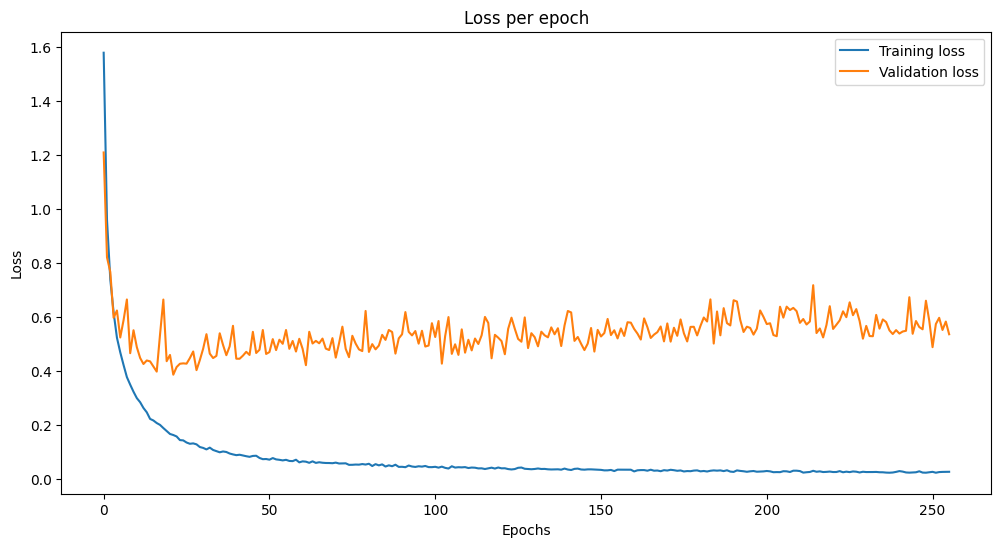

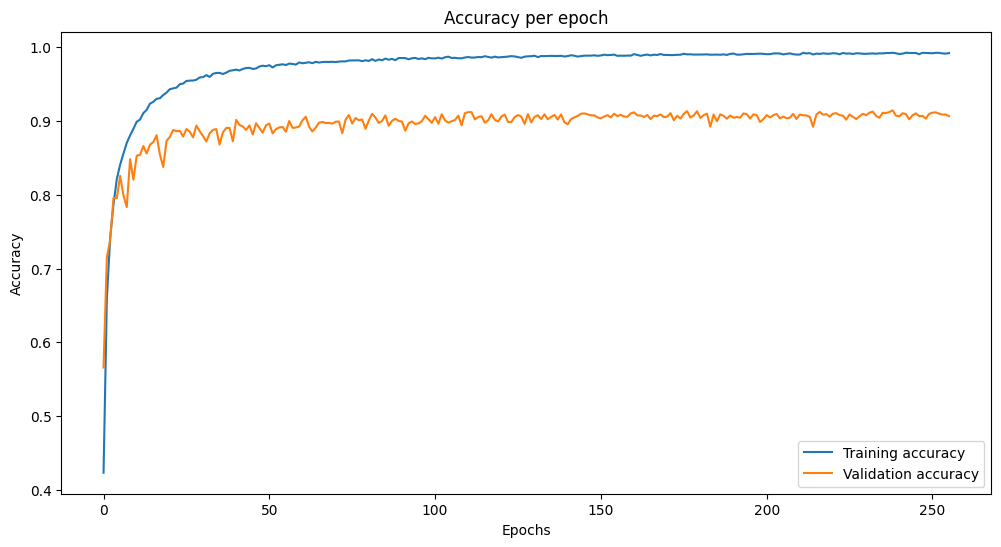

Accuracy:  0.9067


In [12]:
plot_loss(train_loss_from_scratch, val_loss_from_scratch)
plot_accuracy(accuracy_total_train_from_scratch, accuracy_total_val_from_scratch)

accuracy_from_scratch = test_accuracy(model_from_scratch, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_from_scratch)

# CNN1 ResNet Features extraction

### Model

In [13]:
# Importing the model
model_resnet_extract = torchvision.models.resnet18(pretrained=True)
print(model_resnet_extract)

# Freezing the convolutional layers
for param in model_resnet_extract.parameters():
    param.requires_grad = False

# Changing the output layer (from 1000 classes to 10)
model_resnet_extract.fc = torch.nn.Linear(512, 10)
print(model_resnet_extract)
total_parameters_resnet_extract = trainable_parameters(model_resnet_extract)
print(f"Number of total trainable parameters: {total_parameters_resnet_extract}")

model_resnet_extract.to(device)
optimizer = torch.optim.AdamW(model_resnet_extract.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [14]:
train_loss_resnet_extract, val_loss_resnet_extract, accuracy_total_train_resnet_extract, accuracy_total_val_resnet_extract, total_time_resnet_extract = train_model(
    model_resnet_extract,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_resnet_extract/",
    0,
    EPOCHS
)

Epoch: 1/256   Train loss: 1.9754   Valid loss: 1.8134   Train acc: 0.3005   Valid acc: 0.3606   Elapsed time: 5.3629 sec   Time left: 1367.5300 sec
Epoch: 2/256   Train loss: 1.8194   Valid loss: 1.7653   Train acc: 0.3611   Valid acc: 0.3808   Elapsed time: 10.6026 sec   Time left: 1330.8291 sec
Epoch: 3/256   Train loss: 1.7934   Valid loss: 1.7601   Train acc: 0.3715   Valid acc: 0.3838   Elapsed time: 15.8853 sec   Time left: 1336.4664 sec
Epoch: 4/256   Train loss: 1.7817   Valid loss: 1.7324   Train acc: 0.3766   Valid acc: 0.3954   Elapsed time: 21.2469 sec   Time left: 1351.0779 sec
Epoch: 5/256   Train loss: 1.7770   Valid loss: 1.7323   Train acc: 0.3817   Valid acc: 0.3933   Elapsed time: 26.5942 sec   Time left: 1341.9884 sec
Epoch: 6/256   Train loss: 1.7686   Valid loss: 1.7500   Train acc: 0.3807   Valid acc: 0.3898   Elapsed time: 31.8468 sec   Time left: 1313.0816 sec
Epoch: 7/256   Train loss: 1.7634   Valid loss: 1.7431   Train acc: 0.3830   Valid acc: 0.3927   Elap

### Evaluation

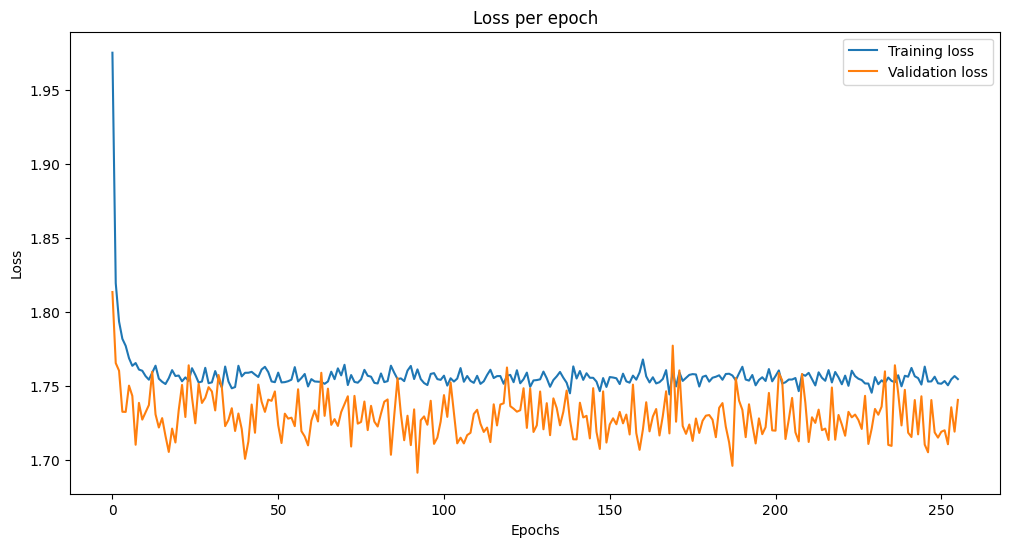

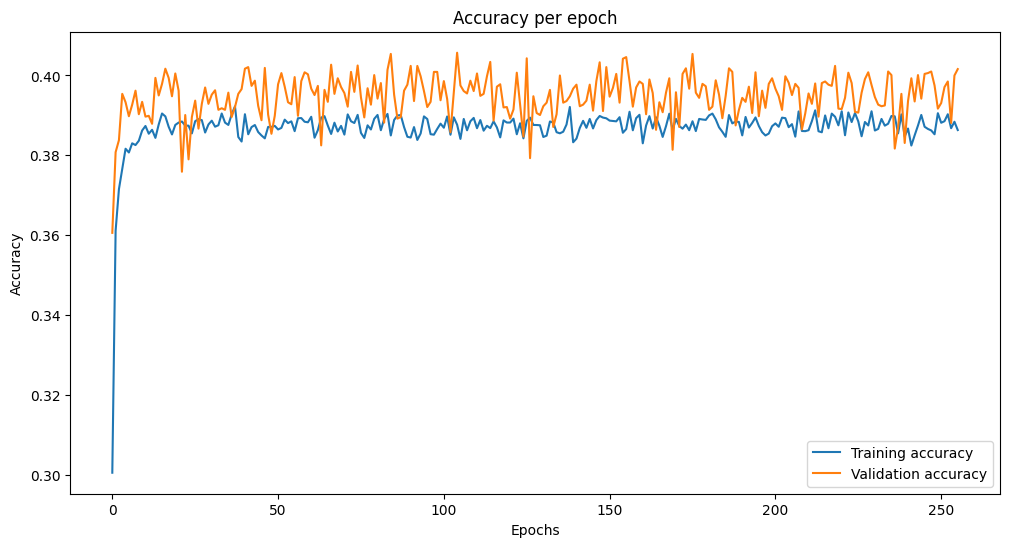

Accuracy:  0.4016


In [15]:
plot_loss(train_loss_resnet_extract, val_loss_resnet_extract)
plot_accuracy(accuracy_total_train_resnet_extract, accuracy_total_val_resnet_extract)

accuracy_resnet_extract = test_accuracy(model_resnet_extract, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_resnet_extract)

# CNN1 ResNet Fine-tuning

### Model

In [16]:
# Importing the model
model_resnet_finetune = torchvision.models.resnet18(pretrained=True)
print(model_resnet_finetune)

# Freezing the convolutional layers except the last one (yes the last layer make +75% of the total parameters)
for param in model_resnet_finetune.parameters():
    param.requires_grad = False
for param in model_resnet_finetune.layer4.parameters():
    param.requires_grad = True

# Changing the output layer (from 1000 classes to 10)
model_resnet_finetune.fc = torch.nn.Linear(512, 10)
print(model_resnet_finetune)
total_parameters_resnet_finetune = trainable_parameters(model_resnet_finetune)
print(f"Number of total trainable parameters: {total_parameters_resnet_finetune}")

model_resnet_finetune.to(device)
optimizer = torch.optim.AdamW(model_resnet_finetune.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [17]:
train_loss_resnet_finetune, val_loss_resnet_finetune, accuracy_total_train_resnet_finetune, accuracy_total_val_resnet_finetune, total_time_resnet_finetune = train_model(
    model_resnet_finetune,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_resnet_finetune/",
    0,
    EPOCHS
)

Epoch: 1/256   Train loss: 1.3832   Valid loss: 1.1500   Train acc: 0.5153   Valid acc: 0.6077   Elapsed time: 5.8332 sec   Time left: 1487.4738 sec
Epoch: 2/256   Train loss: 1.1497   Valid loss: 1.1581   Train acc: 0.5993   Valid acc: 0.6234   Elapsed time: 11.5368 sec   Time left: 1448.6718 sec
Epoch: 3/256   Train loss: 1.0833   Valid loss: 1.0191   Train acc: 0.6188   Valid acc: 0.6469   Elapsed time: 17.3296 sec   Time left: 1465.5108 sec
Epoch: 4/256   Train loss: 1.0453   Valid loss: 0.9921   Train acc: 0.6317   Valid acc: 0.6650   Elapsed time: 23.0541 sec   Time left: 1442.5147 sec
Epoch: 5/256   Train loss: 1.0116   Valid loss: 0.9512   Train acc: 0.6447   Valid acc: 0.6704   Elapsed time: 28.7633 sec   Time left: 1432.9423 sec
Epoch: 6/256   Train loss: 0.9868   Valid loss: 1.0516   Train acc: 0.6534   Valid acc: 0.6693   Elapsed time: 34.4796 sec   Time left: 1429.0242 sec
Epoch: 7/256   Train loss: 0.9580   Valid loss: 0.9496   Train acc: 0.6606   Valid acc: 0.6684   Elap

### Evaluation

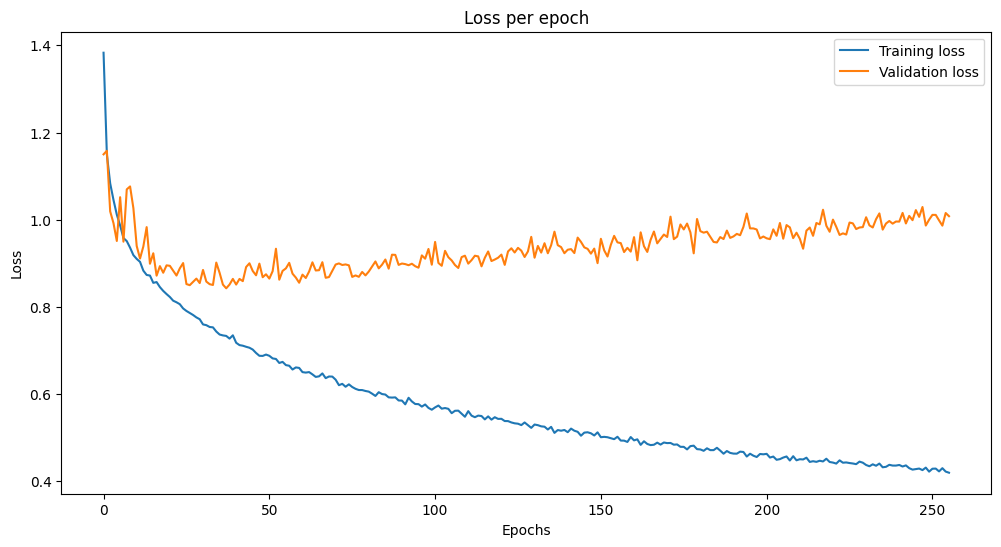

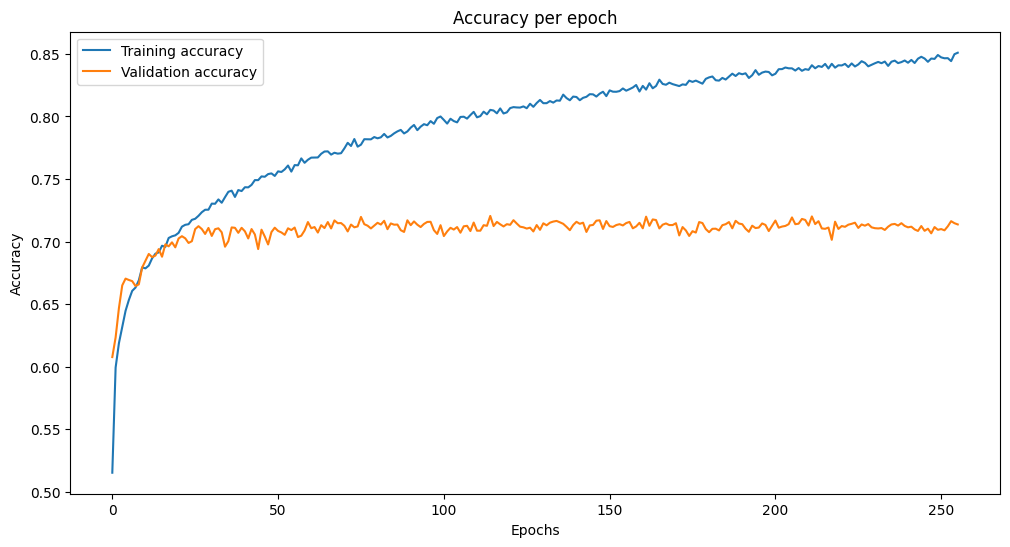

Accuracy:  0.7137


In [18]:
plot_loss(train_loss_resnet_finetune, val_loss_resnet_finetune)
plot_accuracy(accuracy_total_train_resnet_finetune, accuracy_total_val_resnet_finetune)

accuracy_resnet_finetune = test_accuracy(model_resnet_finetune, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_resnet_finetune)

# CNN2 SqueezeNet Features extraction

### Model

In [19]:
# Importing the model
model_squeezenet_extract = torchvision.models.squeezenet1_1(pretrained=True)
print(model_squeezenet_extract)

# Freezing the features layers
for param in model_squeezenet_extract.features.parameters():
    param.requires_grad = False

# Changing the classifier layer (from 1000 classes to 10)
model_squeezenet_extract.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Conv2d(512, 10, kernel_size=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
)
print(model_squeezenet_extract)
total_parameters_squeezenet_extract = trainable_parameters(model_squeezenet_extract)
print(f"Number of total trainable parameters: {total_parameters_squeezenet_extract}")

model_squeezenet_extract.to(device)
optimizer = torch.optim.AdamW(model_squeezenet_extract.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 94.8MB/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

### Training

In [20]:
train_loss_squeezenet_extract, val_loss_squeezenet_extract, accuracy_total_train_squeezenet_extract, accuracy_total_val_squeezenet_extract, total_time_squeezenet_extract = train_model(
    model_squeezenet_extract,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_squeezenet_extract/",
    0,
    EPOCHS
)

Epoch: 1/256   Train loss: 2.7761   Valid loss: 2.2867   Train acc: 0.1074   Valid acc: 0.1036   Elapsed time: 5.4530 sec   Time left: 1390.5056 sec
Epoch: 2/256   Train loss: 2.2881   Valid loss: 2.2619   Train acc: 0.1071   Valid acc: 0.1147   Elapsed time: 10.7723 sec   Time left: 1351.0258 sec
Epoch: 3/256   Train loss: 2.2816   Valid loss: 2.2452   Train acc: 0.1106   Valid acc: 0.1189   Elapsed time: 15.9089 sec   Time left: 1299.5356 sec
Epoch: 4/256   Train loss: 2.2733   Valid loss: 2.2392   Train acc: 0.1161   Valid acc: 0.1245   Elapsed time: 21.1763 sec   Time left: 1327.3177 sec
Epoch: 5/256   Train loss: 2.2584   Valid loss: 2.2326   Train acc: 0.1237   Valid acc: 0.1223   Elapsed time: 26.2808 sec   Time left: 1281.1420 sec
Epoch: 6/256   Train loss: 2.2555   Valid loss: 2.2146   Train acc: 0.1239   Valid acc: 0.1390   Elapsed time: 31.3725 sec   Time left: 1272.9076 sec
Epoch: 7/256   Train loss: 2.2501   Valid loss: 2.2136   Train acc: 0.1258   Valid acc: 0.1336   Elap

### Evaluation

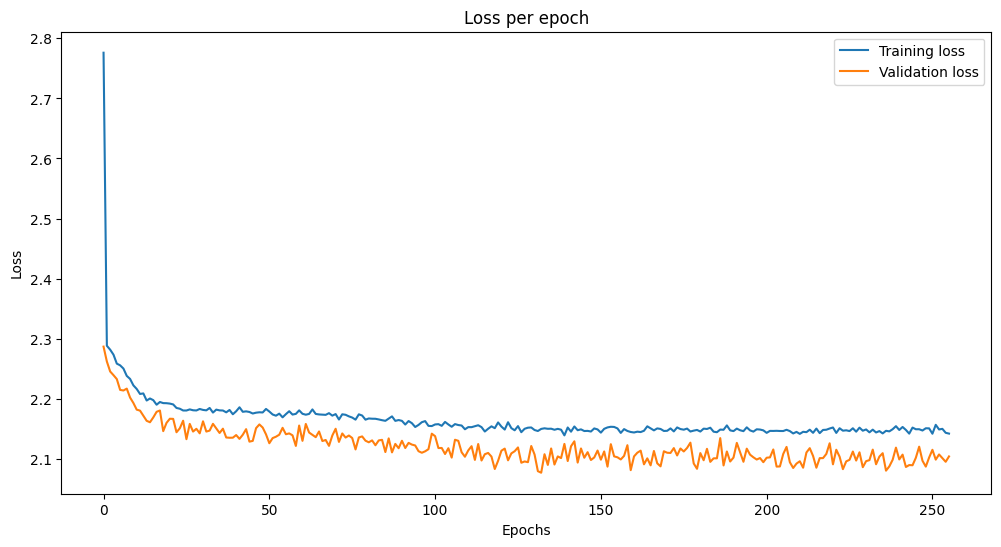

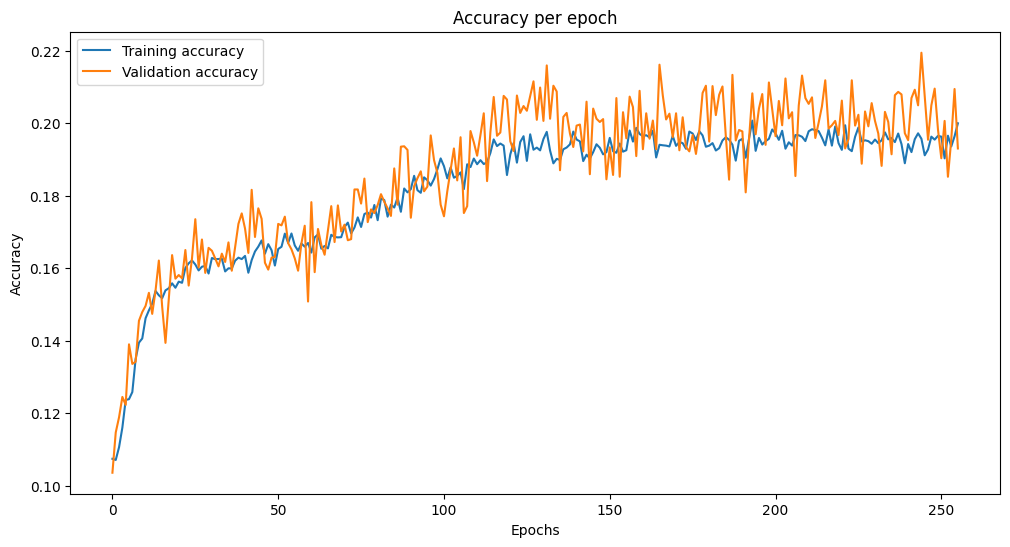

Accuracy:  0.193


In [21]:
plot_loss(train_loss_squeezenet_extract, val_loss_squeezenet_extract)
plot_accuracy(accuracy_total_train_squeezenet_extract, accuracy_total_val_squeezenet_extract)

accuracy_squeezenet_extract = test_accuracy(model_squeezenet_extract, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_squeezenet_extract)

# CNN2 SqueezeNet Fine-tuning

### Model

In [22]:
# Importing the model
model_squeezenet_finetune = torchvision.models.squeezenet1_1(pretrained=True)
total_parameters = sum(p.numel() for p in model_squeezenet_finetune.parameters())
print(f"Number of total trainable parameters: {total_parameters}")
print(model_squeezenet_finetune)

# Freezing the features layers except the last two ones
for param in model_squeezenet_finetune.features[:-2].parameters():
    param.requires_grad = False

# Changing the classifier layer (from 1000 classes to 10)
model_squeezenet_finetune.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Conv2d(512, 10, kernel_size=(1, 1)),
    torch.nn.ReLU(inplace=True),
    torch.nn.AdaptiveAvgPool2d((1, 1))
)
print(model_squeezenet_finetune)
total_parameters_squeezenet_finetune = trainable_parameters(model_squeezenet_finetune)
print(f"Number of total trainable parameters: {total_parameters_squeezenet_finetune}")

model_squeezenet_finetune.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model_squeezenet_finetune.parameters()), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

Number of total trainable parameters: 1235496
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation

### Training

In [23]:
train_loss_squeezenet_finetune, val_loss_squeezenet_finetune, accuracy_total_train_squeezenet_finetune, accuracy_total_val_squeezenet_finetune, total_time_squeezenet_finetune = train_model(
    model_squeezenet_finetune,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_squeezenet_finetune/",
    0,
    EPOCHS
)

Epoch: 1/256   Train loss: 2.2941   Valid loss: 2.0361   Train acc: 0.1519   Valid acc: 0.2884   Elapsed time: 5.8339 sec   Time left: 1487.6459 sec
Epoch: 2/256   Train loss: 2.0563   Valid loss: 1.7977   Train acc: 0.2538   Valid acc: 0.3715   Elapsed time: 11.6582 sec   Time left: 1479.2934 sec
Epoch: 3/256   Train loss: 1.8613   Valid loss: 1.6014   Train acc: 0.3337   Valid acc: 0.4309   Elapsed time: 17.5480 sec   Time left: 1490.0733 sec
Epoch: 4/256   Train loss: 1.7446   Valid loss: 1.5695   Train acc: 0.3804   Valid acc: 0.4430   Elapsed time: 23.2218 sec   Time left: 1429.7673 sec
Epoch: 5/256   Train loss: 1.6722   Valid loss: 1.5100   Train acc: 0.4151   Valid acc: 0.4745   Elapsed time: 28.9600 sec   Time left: 1440.2137 sec
Epoch: 6/256   Train loss: 1.6313   Valid loss: 1.4845   Train acc: 0.4263   Valid acc: 0.4825   Elapsed time: 34.9080 sec   Time left: 1486.9331 sec
Epoch: 7/256   Train loss: 1.5964   Valid loss: 1.4639   Train acc: 0.4415   Valid acc: 0.4832   Elap

### Evaluation

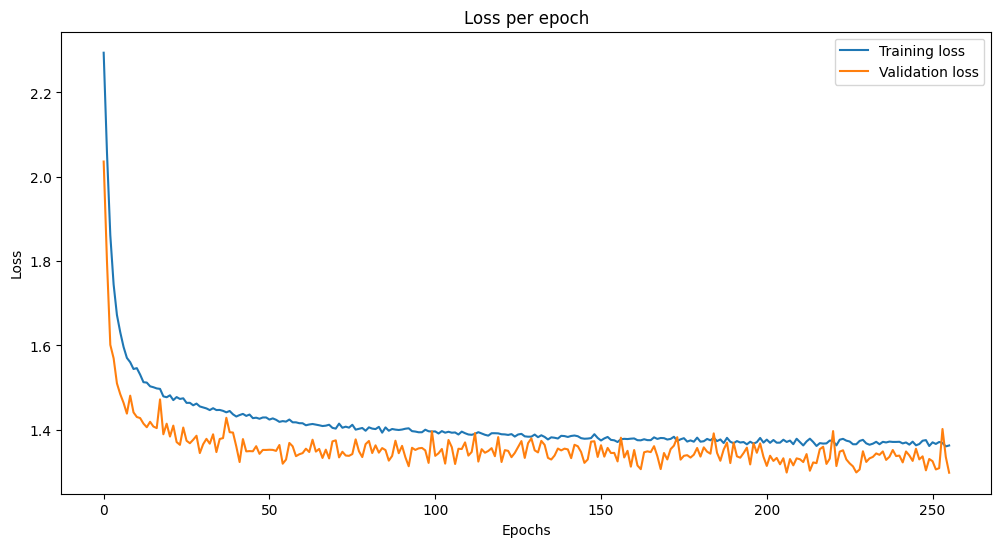

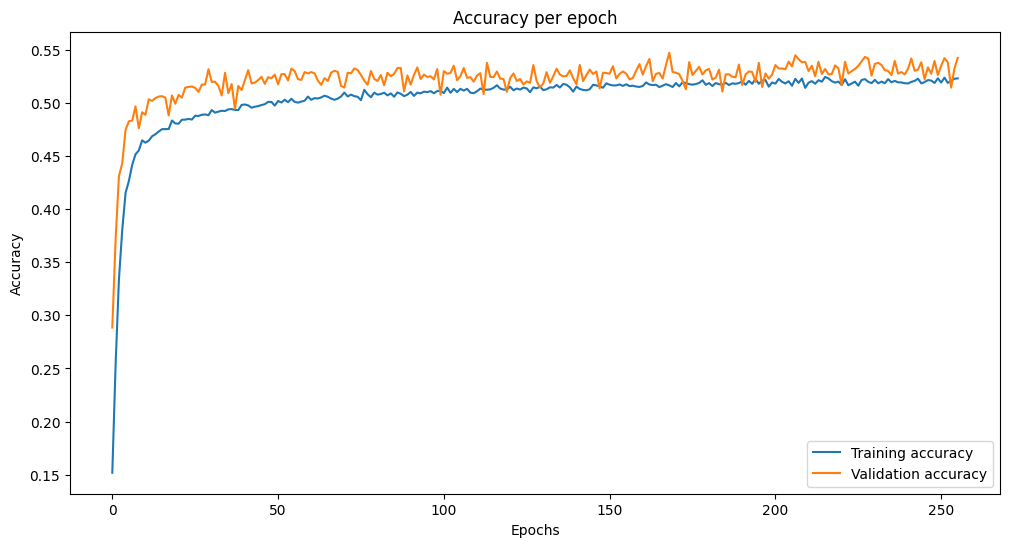

Accuracy:  0.5422


In [24]:
plot_loss(train_loss_squeezenet_finetune, val_loss_squeezenet_finetune)
plot_accuracy(accuracy_total_train_squeezenet_finetune, accuracy_total_val_squeezenet_finetune)

accuracy_squeezenet_finetune = test_accuracy(model_squeezenet_finetune, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_squeezenet_finetune)

# Comparison

### Plot

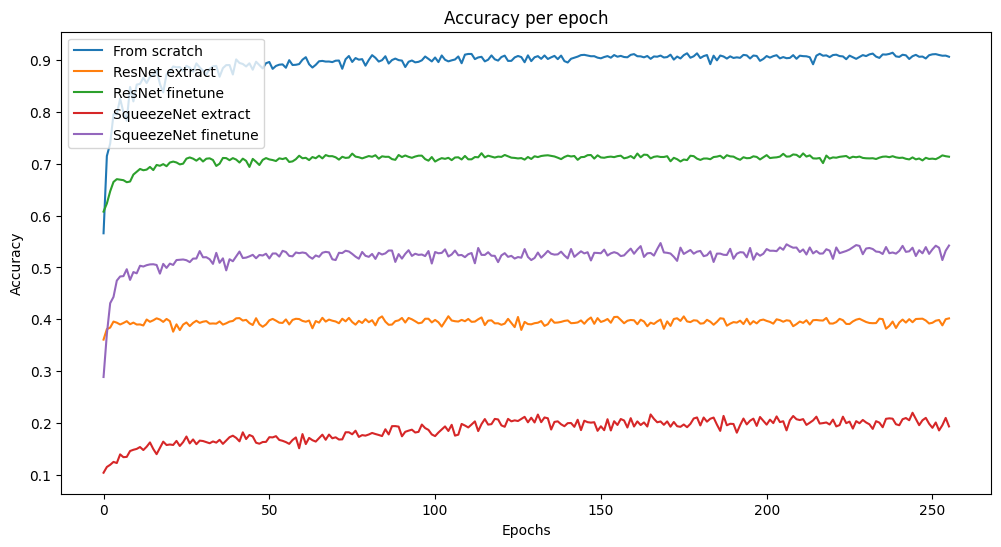

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(accuracy_total_val_from_scratch, label='From scratch')
plt.plot(accuracy_total_val_resnet_extract, label='ResNet extract')
plt.plot(accuracy_total_val_resnet_finetune, label='ResNet finetune')
plt.plot(accuracy_total_val_squeezenet_extract, label='SqueezeNet extract')
plt.plot(accuracy_total_val_squeezenet_finetune, label='SqueezeNet finetune')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.show()

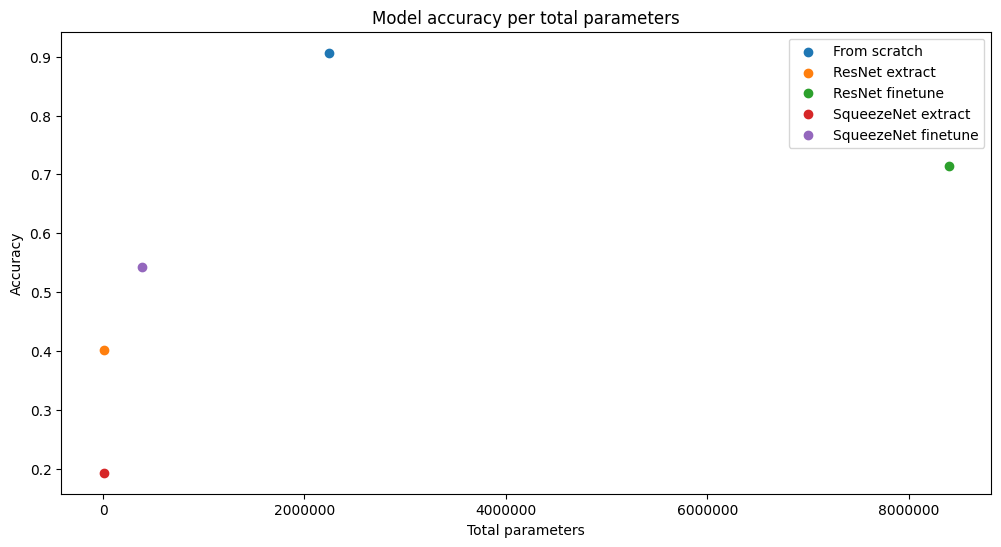

In [26]:
# Plot points model accuracy per parameters count
plt.figure(figsize=(12, 6))
plt.scatter(total_parameters_from_scratch, accuracy_from_scratch, label='From scratch')
plt.scatter(total_parameters_resnet_extract, accuracy_resnet_extract, label='ResNet extract')
plt.scatter(total_parameters_resnet_finetune, accuracy_resnet_finetune, label='ResNet finetune')
plt.scatter(total_parameters_squeezenet_extract, accuracy_squeezenet_extract, label='SqueezeNet extract')
plt.scatter(total_parameters_squeezenet_finetune, accuracy_squeezenet_finetune, label='SqueezeNet finetune')
plt.legend()
plt.xlabel('Total parameters')
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('Accuracy')
plt.title('Model accuracy per total parameters')
plt.show()

### Table

In [27]:
data = {
    "Model": ["From scratch", "ResNet Extract", "ResNet Finetune", "SqueezeNet Extract", "SqueezeNet Finetune"],
    "Number of trainable parameters": [total_parameters_from_scratch, total_parameters_resnet_extract, total_parameters_resnet_finetune, total_parameters_squeezenet_extract, total_parameters_squeezenet_finetune],
    "Test accuracy": [accuracy_from_scratch, accuracy_resnet_extract, accuracy_resnet_finetune, accuracy_squeezenet_extract, accuracy_squeezenet_finetune],
    "Trainning time per epoch": [total_time_from_scratch / EPOCHS, total_time_resnet_extract / EPOCHS, total_time_resnet_finetune / EPOCHS, total_time_squeezenet_extract / EPOCHS, total_time_squeezenet_finetune / EPOCHS]
}
df = pd.DataFrame(data)
df

,Model,Number of trainable parameters,Test accuracy,Trainning time per epoch
0,From scratch,2242078,0.9067,11.168995
1,ResNet Extract,5130,0.4016,5.366553
2,ResNet Finetune,8398858,0.7137,5.804516
3,SqueezeNet Extract,5130,0.1930,5.248037
4,SqueezeNet Finetune,391306,0.5422,5.652347
